In [1]:
import os
import sys
path_to_this_notebook = os.path.abspath('.')
PATH_TO_PROJECT = path_to_this_notebook[: path_to_this_notebook.find('notebooks')]
sys.path.append(PATH_TO_PROJECT)
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

import numpy as np
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt

from src.deep_learning.soundtype_classifier.classifier_datasets import create_data_for_classifier
from src.metadata_processing.load_data import load_recordings_metadata, load_sounds
from collections import defaultdict
from src.visualization.plotting_utils import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from src.deep_learning.neural_networks.create_conv_model import create_conv_model
from IPython.display import HTML, Javascript, display

def restart_kernel_and_run_all_cells():
    display(HTML(
        '''
            <script>
                code_show = false;
                function restart_run_all(){
                    IPython.notebook.kernel.restart();
                    setTimeout(function(){
                        IPython.notebook.execute_all_cells();
                    }, 10000)
                }
                function code_toggle() {
                    if (code_show) {
                        $('div.input').hide(200);
                    } else {
                        $('div.input').show(200);
                    }
                    code_show = !code_show
                }
                code_toggle() 
                restart_run_all()
            </script>

        '''
    ))

%load_ext autoreload
%autoreload 2
%matplotlib inline

2022-05-29 16:47:10.590115: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-05-29 16:47:11.494667: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-29 16:47:11.495146: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-05-29 16:47:11.524697: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-29 16:47:11.524788: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3070 computeCapability: 8.6
coreClock: 1.83GHz coreCount: 46 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2022-05-29 16:47:11.524802: I tensorflow/stream_executor/platform/def

In [2]:
path_to_recordings_metadata = PATH_TO_PROJECT + 'data/'
recordings_metadata_name = 'recordings_metadata.csv'

# What data to use
dates = 'all'
colonies = ['stark', 'lannister', 'martell', 'targaryen', 'baratheon', 'tyrell', 'arryn']
colonies = ['nmrkleinannotated']
experiments = 'all'
stages = ['traced and checked', 'labeled and checked', 'split and checked',]
classes_to_drop = ['weirdo', 'badsplit', 'noise', 'sound']
max_sounds_per_class = {'softchirp': 4000}
max_sound_length = 12000
min_sound_length = 1337
min_sound_occurrences = 30
# Denoising parameters
use_rec_denoising = False
rec_denoising_params = {'stationary': False, 'n_fft': 512, 'time_constant_s': 0.05, 
                        'freq_mask_smooth_hz': 500, 'time_mask_smooth_ms': 10}
# Sounds metadata parameters
classes_balance_factor = 5/7
train_ratio = .7
columns_to_copy = ['colony', 'ratids', 'date', 'experiment']
# Processing features
frequency_threshold = 3000
sr = 22050
n_fft = 512
n_mel = 80
t_dim = 64
use_melspecs = True
target_shape = (n_mel, t_dim) if use_melspecs else (80, 64)

extract_specs_params = {'num_freq_bins': 80,
                        'num_time_bins': 64,
                        'nperseg': 512, 
                        'noverlap': None, 
                        'min_freq': 2000,
                        'max_freq': 11025,
                        'spec_min_val': -10, 
                        'spec_max_val': 0,
                        'remove_dc_offset': True, 
                        'mel': False, 
                        'max_dur': 0.4, 
                        'time_stretch': True}


# Data augmentation parameters
wave_augment_params = {'augment': False, 
                       'times_each_sound': 4, 
                       'stretching_lims': None,
                       'add_noise_lims': (0.001, 0.005), }
times_augment_im = 5
#times_augment_im = 10
augment_im = True
# Where to store
path_to_save = None
dataset_name = None
seed = np.random.randint(10000000)
path_to_models = PATH_TO_PROJECT + 'multi-runs_classifier/nmr/'
augment_str = 'no-augment' if (times_augment_im == 1 or not augment_im) else 'im-augment=%d' % times_augment_im
specs_str = 'mel-specs' if use_melspecs else 'new-specs'
experiment_name = ('seed%d_%s_rec-denoise=%s_highpass=%s' % (seed, specs_str, 
                                                             use_rec_denoising, frequency_threshold))
print('Experiment:', experiment_name)

Experiment: seed4345251_mel-specs_rec-denoise=False_highpass=3000


In [3]:
# Create config dictionary
all_params_dict = {'sr': sr,
                   
                   'recs_metadata': 
                       {'dates': dates, 'colonies': colonies, 'experiments': experiments, 'stages': stages,
                        'path_to_recordings_metadata': path_to_recordings_metadata, 
                        'recordings_metadata_name': recordings_metadata_name},
                   
                   'rec_denoising':
                       {'use_rec_denoising': use_rec_denoising, 'rec_denoising_params': rec_denoising_params},
                   
                   'sounds_metadata':
                       {'classes_to_drop': classes_to_drop, 'max_sounds_per_class': max_sounds_per_class, 
                        'max_sound_length': max_sound_length, 'min_sound_length': min_sound_length, 
                        'min_sound_occurrences': min_sound_occurrences,
                        'classes_balance_factor': classes_balance_factor, 'train_ratio': train_ratio,
                        'columns_to_copy': columns_to_copy, 'random_seed': seed},
                   
                   'features': 
                       {'target_shape': target_shape, 'frequency_threshold': frequency_threshold,
                        'n_fft': n_fft, 'n_mel': n_mel, 'wave_augment_params': wave_augment_params, 
                        'use_melspecs': use_melspecs,  'extract_specs_params': extract_specs_params,
                        'times_augment_im': times_augment_im,  'augment_im': augment_im,}
                  }

In [4]:
recs_metadata, recs_dict = load_recordings_metadata(path_to_recordings_metadata, recordings_metadata_name,
                                                    dates, colonies, experiments, stages, {})

Using 8 recordings


In [5]:
for _ in range(3):
    seed = np.random.randint(10000000)
    experiment_name = ('seed%d_%s_rec-denoise=%s_highpass=%s' % (seed, specs_str, 
                                                                 use_rec_denoising, frequency_threshold))
    all_params_dict['sounds_metadata']['random_seed'] = seed
    print('Experiment:', experiment_name)
    # Create and save datasets
    (all_classes, sounds_metadata_train, sounds_npy_train, melspecs_train,  sounds_metadata_test, 
     sounds_npy_test,  melspecs_test) = create_data_for_classifier(all_params_dict, dataset_name, 
                                                                   path_to_save, save=False, 
                                                                   preloaded_recs_dict=recs_dict)


    img_shape = melspecs_train.shape[1:]
    y_train_str = sounds_metadata_train['cl']
    y_test_str = sounds_metadata_test['cl']
    all_classes_str = sorted(list(set(y_train_str.unique()) | set(y_test_str.unique())))
    y_train = y_train_str.apply(lambda x: all_classes_str.index(x))
    y_test = y_test_str.apply(lambda x: all_classes_str.index(x))

    if len(melspecs_train.shape) < 4:
        melspecs_train = melspecs_train.reshape((*melspecs_train.shape, 1))
    if len(melspecs_test.shape) < 4:
        melspecs_test = melspecs_test.reshape((*melspecs_test.shape, 1))
    with tf.device('/gpu:0'):
        model = create_conv_model(img_shape, all_classes_str)
        epochs = 15
        model.fit(melspecs_train, y_train, epochs=epochs, batch_size=256, validation_data=(melspecs_test, y_test))

    model.save(path_to_models + experiment_name)

    #y_train_predicted_probs = model.predict(melspecs_train)
    #y_train_predicted = np.argmax(y_train_predicted_probs, 1)
    y_test_predicted_probs = model.predict(melspecs_test)
    #y_test_predicted = np.argmax(y_test_predicted_probs, 1)

    np.save(path_to_models + experiment_name + '/y_test_predicted_probs.npy', y_test_predicted_probs)
    np.save(path_to_models + experiment_name + '/y_test.npy', y_test)
    np.save(path_to_models + experiment_name + '/all_classes_str.npy', all_classes_str)
    if len(os.listdir(path_to_models)) < 6:
        restart_kernel_and_run_all_cells()
    else:
        break

Experiment: seed8944131_mel-specs_rec-denoise=False_highpass=3000
Using 8 recordings
Using 5 recordings (3712 sounds)for train and  3 recordings (2561 sounds)for test

############ Classes in train:############ 

softchirp    2385
whistle       491
downsweep     438
phee          186
tweet          82
vtrill         50
combotwo       30
loudchirp      27
combo          23
Name: cl, dtype: int64
############ Classes in test: ############ 

softchirp    1614
whistle       370
downsweep     241
phee          176
loudchirp      71
vtrill         40
tweet          20
combo          20
combotwo        9
Name: cl, dtype: int64
After balancing:
############ Classes in train:############ 

softchirp    2385
whistle      1473
downsweep    1314
phee         1116
tweet         902
vtrill        750
combotwo      660
loudchirp     648
combo         621
Name: cl, dtype: int64
############ Classes in test: ############ 

softchirp    1614
whistle       370
downsweep     241
phee          176
loudchir

/home/gr1/Projects/naked-mole-rats/src/metadata_processing/process_sounds_metadata.py:37: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  sounds_metadata = pd.concat(sounds_metadata, 0).reset_index(drop=True)
/home/gr1/Projects/naked-mole-rats/src/deep_learning/soundtype_classifier/classifier_datasets.py:26: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  return pd.concat(sounds_metadata_balanced, 0)
/home/gr1/Projects/naked-mole-rats/src/deep_learning/soundtype_classifier/classifier_datasets.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for sound in sounds_npy_train])
/home/gr1/Projects/naked-mole-rats/src/deep_l

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 80, 64, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 40, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 16, 64)        3

2022-05-29 16:47:33.275191: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-29 16:47:33.295379: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3799900000 Hz


Epoch 1/15


2022-05-29 16:47:33.674398: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-05-29 16:47:34.019704: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-05-29 16:47:34.026651: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2022-05-29 16:47:35.455118: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:47:35.455220: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: /usr/local/cuda-11.0/bin/ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to custo

2022-05-29 16:47:38.524246: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:47:38.647045: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:47:38.775045: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:47:38.900277: W tensorflow/stream_executor/gpu/

2022-05-29 16:47:42.159387: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:47:42.283092: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:47:42.421488: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:47:42.544979: W tensorflow/stream_executor/gpu/

2022-05-29 16:47:45.681990: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:47:45.806444: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:47:45.940889: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:47:46.064597: W tensorflow/stream_executor/gpu/

2022-05-29 16:47:49.163206: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:47:49.284992: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:47:49.407175: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:47:49.557895: W tensorflow/stream_executor/gpu/

2022-05-29 16:47:52.408414: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:47:52.532409: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:47:52.657188: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:47:52.780104: W tensorflow/stream_executor/gpu/

2022-05-29 16:47:55.893401: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:47:56.016758: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:47:56.152746: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:47:56.274338: W tensorflow/stream_executor/gpu/

2022-05-29 16:47:59.541696: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:47:59.671120: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:47:59.820536: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:47:59.949658: W tensorflow/stream_executor/gpu/

2022-05-29 16:48:03.272364: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:48:03.401216: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:48:03.536772: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:48:03.665652: W tensorflow/stream_executor/gpu/

2022-05-29 16:48:06.923105: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:48:07.058426: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:48:07.217145: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:48:07.346220: W tensorflow/stream_executor/gpu/

  1/193 [..............................] - ETA: 1:54:41 - loss: 2.6734 - sparse_categorical_accuracy: 0.0898

2022-05-29 16:48:09.016433: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:48:09.139217: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'



191/193 [============================>.] - ETA: 0s - loss: 2.0330 - sparse_categorical_accuracy: 0.2497

2022-05-29 16:48:16.454573: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:48:16.581402: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:48:16.709456: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:48:16.836356: W tensorflow/stream_executor/gpu/

2022-05-29 16:48:20.082370: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:48:20.206261: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:48:20.336065: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:48:20.460308: W tensorflow/stream_executor/gpu/

2022-05-29 16:48:23.774938: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:48:23.906261: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:48:24.034714: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:48:24.159001: W tensorflow/stream_executor/gpu/

2022-05-29 16:48:27.403660: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:48:27.530539: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:48:27.658572: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:48:27.797092: W tensorflow/stream_executor/gpu/

2022-05-29 16:48:31.046400: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:48:31.177073: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:48:31.319283: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:48:31.450237: W tensorflow/stream_executor/gpu/

2022-05-29 16:48:34.814574: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:48:34.947500: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:48:35.082587: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:48:35.214796: W tensorflow/stream_executor/gpu/

2022-05-29 16:48:38.447518: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:48:38.574038: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:48:38.707691: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:48:38.832522: W tensorflow/stream_executor/gpu/

2022-05-29 16:48:42.029740: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:48:42.157645: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:48:42.303852: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:48:42.433399: W tensorflow/stream_executor/gpu/

2022-05-29 16:48:45.697374: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:48:45.826227: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:48:45.958265: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:48:46.084329: W tensorflow/stream_executor/gpu/

2022-05-29 16:48:49.387755: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:48:49.515208: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:48:49.650391: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:48:49.778643: W tensorflow/stream_executor/gpu/

193/193 [==============================] - ETA: 0s - loss: 2.0317 - sparse_categorical_accuracy: 0.2501

2022-05-29 16:48:50.677864: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:48:50.803304: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:48:51.447710: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:48:51.575419: W tensorflow/stream_executor/gpu/

2022-05-29 16:48:54.844719: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:48:54.971458: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:48:55.103752: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:48:55.232012: W tensorflow/stream_executor/gpu/

2022-05-29 16:48:58.477262: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:48:58.603672: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:48:58.739020: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:48:58.869060: W tensorflow/stream_executor/gpu/

2022-05-29 16:49:02.189270: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:49:02.323694: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:49:02.457416: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:49:02.598726: W tensorflow/stream_executor/gpu/

193/193 [==============================] - 93s 297ms/step - loss: 2.0310 - sparse_categorical_accuracy: 0.2503 - val_loss: 1.7278 - val_sparse_categorical_accuracy: 0.5377
Epoch 2/15
  1/193 [..............................] - ETA: 7s - loss: 1.7825 - sparse_categorical_accuracy: 0.3203

2022-05-29 16:49:05.947281: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:49:06.073829: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'



193/193 [==============================] - 7s 39ms/step - loss: 1.7857 - sparse_categorical_accuracy: 0.3201 - val_loss: 1.6494 - val_sparse_categorical_accuracy: 0.5490
Epoch 3/15
193/193 [==============================] - 7s 39ms/step - loss: 1.7674 - sparse_categorical_accuracy: 0.3292 - val_loss: 1.6224 - val_sparse_categorical_accuracy: 0.5521
Epoch 4/15
193/193 [==============================] - 7s 39ms/step - loss: 1.7636 - sparse_categorical_accuracy: 0.3271 - val_loss: 1.5810 - val_sparse_categorical_accuracy: 0.5549
Epoch 5/15
193/193 [==============================] - 7s 39ms/step - loss: 1.7530 - sparse_categorical_accuracy: 0.3313 - val_loss: 1.5568 - val_sparse_categorical_accuracy: 0.5510
Epoch 6/15
193/193 [==============================] - 7s 39ms/step - loss: 1.7397 - sparse_categorical_accuracy: 0.3373 - val_loss: 1.4331 - val_sparse_categorical_accuracy: 0.5677
Epoch 7/15
193/193 [==============================] - 7s 39ms/step - loss: 1.6031 - sparse_categorical_acc

2022-05-29 16:50:50.339087: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/gr1/Projects/naked-mole-rats/multi-runs_classifier/nmr/seed8944131_mel-specs_rec-denoise=False_highpass=3000/assets


2022-05-29 16:50:51.314908: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:50:51.445428: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:50:51.580653: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:50:51.711738: W tensorflow/stream_executor/gpu/

2022-05-29 16:50:55.065681: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:50:55.196722: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:50:55.335659: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:50:55.468263: W tensorflow/stream_executor/gpu/

2022-05-29 16:50:58.882191: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:50:59.014813: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:50:59.147768: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:50:59.278946: W tensorflow/stream_executor/gpu/

2022-05-29 16:51:02.681993: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:51:02.813384: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:51:02.943285: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-29 16:51:03.076857: W tensorflow/stream_executor/gpu/

### Eval

In [8]:
base_path = PATH_TO_PROJECT + 'multi-runs_classifier/'
exp_types = os.listdir(base_path)

In [11]:
accuracies_dict = defaultdict(list)
for exp in exp_types:
    path_to_models = base_path + exp + '/'
    for f in os.listdir(path_to_models):
        y_test_predicted_probs = np.load(path_to_models + f + '/y_test_predicted_probs.npy')
        y_test_predicted = np.argmax(y_test_predicted_probs, 1)
        y_test = np.load(path_to_models + f + '/y_test.npy')
        all_classes_str = np.load(path_to_models + f + '/all_classes_str.npy')
        type_of_specs = 'new-specs' if 'new-specs' in f else 'mel-specs'
        run_code = '%s-%s' % (exp, type_of_specs)
        accuracies_dict[run_code].append((y_test_predicted == y_test).mean())

In [14]:
x = []
y_mean = []
y_std = []
for run_name, accs in accuracies_dict.items():
    x.append(run_name)
    y_mean.append(np.mean(accs))
    y_std.append(np.std(accs))

/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  import sys


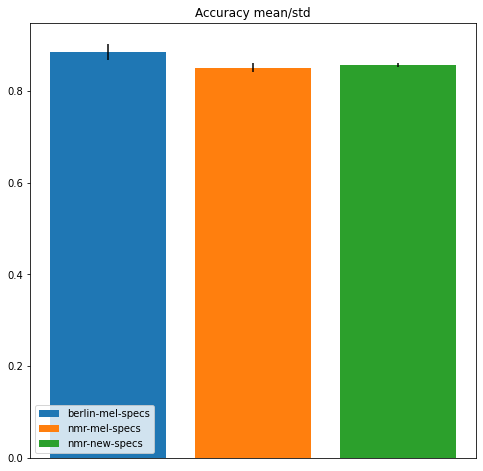

In [50]:
plt.figure(figsize=(8, 8))
for i in range(len(x)):
    plt.bar(x[i], y_mean[i], label=x[i])
    plt.errorbar(x[i], y_mean[i], yerr = y_std[i], fmt='',ecolor = 'black', color='white')
    #plt.xlim(0.9, 1.1)
    plt.title('Accuracy mean/std')
_ = plt.xticks([])
_ = plt.legend()

In [51]:
y_test

array([5, 5, 5, ..., 5, 4, 2])

In [52]:
all_classes_str

array(['combo', 'combotwo', 'downsweep', 'loudchirp', 'phee', 'softchirp',
       'tweet', 'vtrill', 'whistle'], dtype='<U9')

In [53]:
y_test_predicted

array([5, 5, 2, ..., 5, 6, 2])